In [1]:
import matplotlib.pyplot as plt
import imageio
import glob
import random
import os
import numpy as np
import math
import itertools
import time
import datetime
import cv2
from pathlib import Path
from PIL import Image


from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [2]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode='train'):
        self.transform = transforms.Compose(transforms_)

        self.files = sorted(glob.glob(os.path.join(root, mode) + '/*.*'))
        if mode == 'val':
            self.files.extend(sorted(glob.glob(os.path.join(root, 'val') + '/*.*')))

    def __getitem__(self, index):

        img = Image.open(self.files[index % len(self.files)])
        w, h = img.size
        img_A = img.crop((0, 0, w/2, h))
        img_B = img.crop((w/2, 0, w, h))

        if np.random.random() < 0.5:
            img_A = Image.fromarray(np.array(img_A)[:, ::-1, :], 'RGB')
            img_B = Image.fromarray(np.array(img_B)[:, ::-1, :], 'RGB')

        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        return img_A,img_B 

    def __len__(self):
        return len(self.files)

In [3]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)


##############################
#           RESNET
##############################

class ResidualBlock(nn.Module):
    def __init__(self, features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(features, features, 3),
                        nn.InstanceNorm2d(features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(features, features, 3),
                        nn.InstanceNorm2d(features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Encoder(nn.Module):
    def __init__(self, in_channels=3, dim=64, n_downsample=2, shared_block=None):
        super(Encoder, self).__init__()

        # Initial convolution block
        layers = [  nn.ReflectionPad2d(3),
                    nn.Conv2d(in_channels, dim, 7),
                    nn.InstanceNorm2d(64),
                    nn.LeakyReLU(0.2, inplace=True) ]

        # Downsampling
        for _ in range(n_downsample):
            layers += [ nn.Conv2d(dim, dim * 2, 4, stride=2, padding=1),
                        nn.InstanceNorm2d(dim * 2),
                        nn.ReLU(inplace=True) ]
            dim *= 2

        # Residual blocks
        for _ in range(3):
            layers += [ResidualBlock(dim)]

        self.model_blocks = nn.Sequential(*layers)
        self.shared_block = shared_block

    def reparameterization(self, mu):
        Tensor = torch.cuda.FloatTensor if mu.is_cuda else torch.FloatTensor
        z = Variable(Tensor(np.random.normal(0, 1, mu.shape)))
        return z + mu

    def forward(self, x):
        x = self.model_blocks(x)
        mu = self.shared_block(x)
        z = self.reparameterization(mu)
        return mu, z

class Generator(nn.Module):
    def __init__(self, out_channels=3, dim=64, n_upsample=2, shared_block=None):
        super(Generator, self).__init__()

        self.shared_block = shared_block

        layers = []
        dim = dim * 2**n_upsample
        # Residual blocks
        for _ in range(3):
            layers += [ResidualBlock(dim)]

        # Upsampling
        for _ in range(n_upsample):
            layers += [ nn.ConvTranspose2d(dim, dim // 2, 4, stride=2, padding=1),
                        nn.InstanceNorm2d(dim // 2),
                        nn.LeakyReLU(0.2, inplace=True) ]
            dim = dim // 2

        # Output layer
        layers += [ nn.ReflectionPad2d(3),
                    nn.Conv2d(dim, out_channels, 7),
                    nn.Tanh() ]

        self.model_blocks = nn.Sequential(*layers)

    def forward(self, x):
        x = self.shared_block(x)
        x = self.model_blocks(x)
        return x

##############################
#        Discriminator
##############################

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.Conv2d(512, 1, 3, padding=1)
        )

    def forward(self, img):
        return self.model(img)

In [4]:
# parameters

epoch =0 #epoch to start training from
n_epochs =200 #number of epochs of training
batch_size =1 #size of the batches
lr =0.0001 # adam: learning rate
b1 =0.5  # adam: decay of first order momentum of gradient
b2 =0.999   # adam: decay of first order momentum of gradient
decay_epoch =100  # epoch from which to start lr decay
img_height =256 #size of image height
img_width =256 # size of image width
channels =3  #number of image channels
sample_interval =100  #interval between sampling images from generators
checkpoint_interval =-1 # interval between saving model checkpoints
n_downsample =2   # number downsampling layers in encoder
dim =64    #number of filters in first encoder layer

def compute_kl(mu):
    mu_2 = torch.pow(mu, 2)
    loss = torch.mean(mu_2)
    return loss

In [6]:
cuda = True if torch.cuda.is_available() else False
# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_pixel = torch.nn.L1Loss()

# Calculate output of image discriminator (PatchGAN)
patch = (1, img_height // 2**4, img_width // 2**4)

# Dimensionality (channel-wise) of image embedding
shared_dim = dim * 2**n_downsample

# Initialize generator and discriminator
shared_E = ResidualBlock(features=shared_dim)
E1 = Encoder(dim=dim, n_downsample=n_downsample, shared_block=shared_E)
E2 = Encoder(dim=dim, n_downsample=n_downsample, shared_block=shared_E)
shared_G = ResidualBlock(features=shared_dim)
G1 = Generator(dim=dim, n_upsample=n_downsample, shared_block=shared_G)
G2 = Generator(dim=dim, n_upsample=n_downsample, shared_block=shared_G)
D1 = Discriminator()
D2 = Discriminator()

# move to gpu
if cuda:
    E1 = E1.cuda()
    E2 = E2.cuda()
    G1 = G1.cuda()
    G2 = G2.cuda()
    D1 = D1.cuda()
    D2 = D2.cuda()
    criterion_GAN.cuda()
    criterion_pixel.cuda()

# Initialize weights
E1.apply(weights_init_normal)
E2.apply(weights_init_normal)
G1.apply(weights_init_normal)
G2.apply(weights_init_normal)
D1.apply(weights_init_normal)
D2.apply(weights_init_normal)

# Loss weights
lambda_0 = 10   # GAN
lambda_1 = 0.1  # KL (encoded images)
lambda_2 = 100  # ID pixel-wise
lambda_3 = 0.1  # KL (encoded translated images)
lambda_4 = 100  # Cycle pixel-wise

# Optimizers
optimizer_G = torch.optim.Adam(itertools.chain(E1.parameters(), E2.parameters(), G1.parameters(), G2.parameters()),
                                lr=lr, betas=(b1, b2))
optimizer_D1 = torch.optim.Adam(D1.parameters(), lr=lr, betas=(b1, b2))
optimizer_D2 = torch.optim.Adam(D2.parameters(), lr=lr, betas=(b1, b2))



# Learning rate update schedulers
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D1 = torch.optim.lr_scheduler.LambdaLR(optimizer_D1, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D2 = torch.optim.lr_scheduler.LambdaLR(optimizer_D2, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

In [16]:
# Image transformations
transforms_ = [ transforms.Resize((img_height, img_width), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]

dataloader = DataLoader(ImageDataset("facades1", transforms_=transforms_),
                        batch_size=6, shuffle=True)

val_dataloader = DataLoader(ImageDataset("facades1", transforms_=transforms_, mode='val'),
                            batch_size=6, shuffle=False)



In [9]:
def plot2x2Array(image, mask):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image)
    axarr[1].imshow(mask)

    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')

def reverse_transform(image):
    image = image.numpy().transpose((1, 2, 0))
    image = ((image+1)/2*255).astype(np.uint8)
    image = np.clip(image, 0,255)    
    return image

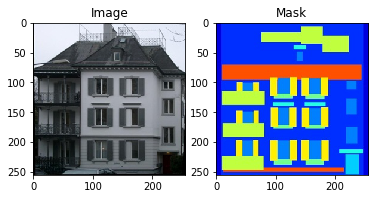

In [26]:
image, mask = next(iter(dataloader))
image = reverse_transform(image[0])
mask = reverse_transform(mask[0])
plot2x2Array(image, mask)

In [30]:
# ----------
#  Training
# ----------
losses = []
num_epochs = 200

# train the network

E1 = E1.train()
E2 = E2.train()
G1 = G1.train()
G2 = G2.train()
D1 = D1.train()
D2 = D2.train()

print_every = 400

for epoch in range(0, num_epochs):
    for i, batch in enumerate(dataloader):

        # Model inputs
        X1 = Variable(batch[0].type(Tensor))
        X2 = Variable(batch[1].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((X1.size(0), *patch))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((X1.size(0), *patch))), requires_grad=False)
        
        # -------------------------------
        #  Train Encoders and Generators
        # -------------------------------

        optimizer_G.zero_grad()

        # Get shared latent representation
        mu1, Z1 = E1(X1)
        mu2, Z2 = E2(X2)

        # Reconstruct images
        recon_X1 = G1(Z1)
        recon_X2 = G2(Z2)

        # Translate images
        fake_X1 = G1(Z2)
        fake_X2 = G2(Z1)

        # Cycle translation
        mu1_, Z1_ = E1(fake_X1)
        mu2_, Z2_ = E2(fake_X2)
        cycle_X1 = G1(Z2_)
        cycle_X2 = G2(Z1_)

        # Losses
        loss_GAN_1  = lambda_0 * criterion_GAN(D1(fake_X1), valid)
        loss_GAN_2  = lambda_0* criterion_GAN(D2(fake_X2), valid)
        loss_KL_1   = lambda_1 * compute_kl(mu1)
        loss_KL_2   = lambda_1 * compute_kl(mu2)
        loss_ID_1   = lambda_2 * criterion_pixel(recon_X1, X1)
        loss_ID_2   = lambda_2 * criterion_pixel(recon_X2, X2)
        loss_KL_1_  = lambda_3 * compute_kl(mu1_)
        loss_KL_2_  = lambda_3 * compute_kl(mu2_)
        loss_cyc_1  = lambda_4 * criterion_pixel(cycle_X1, X1)
        loss_cyc_2  = lambda_4 * criterion_pixel(cycle_X2, X2)

        # Total loss
        loss_G =    loss_KL_1 + \
                    loss_KL_2 + \
                    loss_ID_1 + \
                    loss_ID_2 + \
                    loss_GAN_1 + \
                    loss_GAN_2 + \
                    loss_KL_1_ + \
                    loss_KL_2_ + \
                    loss_cyc_1 + \
                    loss_cyc_2

        loss_G.backward()
        optimizer_G.step()

        # -----------------------
        #  Train Discriminator 1
        # -----------------------

        optimizer_D1.zero_grad()

        loss_D1 =   criterion_GAN(D1(X1), valid) + \
                    criterion_GAN(D1(fake_X1.detach()), fake)

        loss_D1.backward()
        optimizer_D1.step()

        # -----------------------
        #  Train Discriminator 2
        # -----------------------

        optimizer_D2.zero_grad()

        loss_D2 =   criterion_GAN(D2(X2), valid) + \
                    criterion_GAN(D2(fake_X2.detach()), fake)

        loss_D2.backward()
        optimizer_D2.step()
        loss_D =loss_D1 + loss_D2
        
         # Print some loss stats
        if i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, loss_D.item(), loss_G.item()))
    
    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D1.step()
    lr_scheduler_D2.step()


RuntimeError: CUDA out of memory. Tried to allocate 96.00 MiB (GPU 0; 6.00 GiB total capacity; 4.56 GiB already allocated; 74.39 MiB free; 393.00 KiB cached)

In [ ]:
def plot2x3Array(image, mask,predict):
    f, axarr = plt.subplots(1,3,figsize=(15,15))
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    axarr[2].imshow(predict)
    axarr[0].set_title('input')
    axarr[1].set_title('real')
    axarr[2].set_title('fake')

In [ ]:
E1 = E1.eval()
E2 = E2.eval()
G1 = G1.eval()
G2 = G2.eval()
D1 = D1.eval()
D2 = D2.eval()

image, mask = next(iter(val_dataloader))
X1 = Variable(image.type(Tensor))
X2 = Variable(mask.type(Tensor))
_, Z1 = E1(X1)
_, Z2 = E2(X2)
fake_X1 = G1(Z2)
fake_X2 = G2(Z1)
fake_X1 = fake_X1.view(6, 3, 256, 256)
fake_X1 = fake_X1.cpu().detach()
fake_X2 = fake_X2.view(6, 3, 256, 256)
fake_X2 = fake_X2.cpu().detach()

X1 = reverse_transform(X1[i])
X2 = reverse_transform(X2[i])
fake_X1 = reverse_transform(fake_X1[i])
fake_X2 = reverse_transform(fake_X2[i])

plot2x3Array(X1,X2,fake_X2)
plot2x3Array(X2,X1,fake_X1)


In [29]:
torch.cuda.empty_cache()